# Práctico 2: Recomendación de videojuegos

En este práctico trabajaremos con un subconjunto de datos sobre [videojuegos de Steam](http://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data). Para facilitar un poco el práctico, se les dará el conjunto de datos previamente procesado. En este mismo notebook mostraremos el proceso de limpieza, para que quede registro del proceso (de todas maneras, por el tamaño de los datos no recomendamos que pierdan tiempo en el proceso salvo que lo consideren útil a fines personales). 

El conjunto de datos se basa en dos partes: lista de juegos (items), y lista de reviews de usuarios sobre distintos juegos. Este último, en su versión original es muy grande, (pesa 1.3GB), por lo que será solo una muestra del mismo sobre la que trabajarán.

A diferencia del conjunto de datos de LastFM utilizados en el [Práctico 1](./practico1.ipynb), en este caso los datos no están particularmente pensados para un sistema de recomendación, por lo que requerirá de un poco más de trabajo general sobre el dataset.

La idea es que, de manera similar al práctico anterior, realicen un sistema de recomendación. A diferencia del práctico anterior, este será un poco más completo y deberán hacer dos sistemas, uno que, dado un nombre de usuario le recomiende una lista de juegos, y otro que dado el título de un juego, recomiende una lista de juegos similares. Además, en este caso se requiere que el segundo sistema (el que recomienda juegos basado en el nombre de un juego en particular) haga uso de la información de contenido (i.e. o bien harán un filtrado basado en contenido o algo híbrido).

## Obtención y limpieza del conjunto de datos

El conjunto de datos originalmente se encuentra en archivos que deberían ser de formato "JSON". Sin embargo, en realidad es un archivo donde cada línea es un objeto de JSON. Hay un problema no obstante y es que las líneas están mal formateadas, dado que no respetan el estándar JSON de utilizar comillas dobles (**"**) y en su lugar utilizan comillas simples (**'**). Afortunadamente, se pueden evaluar como diccionarios de Python, lo cuál permite trabajarlos directamente.

### Descarga

La siguiente celda descarga los conjuntos de datos crudos. Nuevamente, no es necesario ejecutarla y pueden ir [más abajo](#Conjunto-de-datos-limpio) para ejecutar la celda que descargará el conjunto ya procesado.

In [ ]:
%%bash

mkdir -p data/steam/
curl -L -o data/steam/steam_games.json.gz http://cseweb.ucsd.edu/\~wckang/steam_games.json.gz
curl -L -o data/steam/steam_reviews.json.gz http://cseweb.ucsd.edu/\~wckang/steam_reviews.json.gz

### Carga de datos

Como se dijo, por la naturaleza de los datos, necesitamos utilizar Python para trabajarlos (no podemos leerlos con JSON).

In [30]:
import gzip
from tqdm import tqdm_notebook  # To print a progress bar (comes with Anaconda or can be installed)

with gzip.open("./data/steam/steam_games.json.gz") as fh:
    games = []
    for game in tqdm_notebook(fh, total=32135):
        try:
            games.append(eval(game))
        except SyntaxError:
            continue

print("Loaded {} games".format(len(games)))

with gzip.open("./data/steam/steam_reviews.json.gz") as fh:
    reviews = []
    for review in tqdm_notebook(fh, total=7793069):
        try:
            reviews.append(eval(review))
        except SyntaxError:
            continue

print("Loaded {} user reviews".format(len(reviews)))


Loaded 32135 games


FileNotFoundError: [Errno 2] No such file or directory: './data/steam/steam_reviews.json.gz'

### Exploración de los datos

En esta parte necesitamos revisar la estructura general, para poder pasarlos a un formato más amigable (e.g. CSV).

In [ ]:
games[0]

In [ ]:
reviews[0]

### Transformación de los datos

Viendo los datos que tenemos de cada tipo, podemos utilizar pandas para leer los registros y trabajar con algo más sencillo.

In [6]:
import pandas as pd

In [7]:
games = pd.DataFrame.from_records(games)
games.head(3)

NameError: name 'games' is not defined

In [32]:
reviews = pd.DataFrame.from_records(reviews)
reviews.head(3)

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
0,SPejsMan,227940,0,Just one word... Balance!,23.0,92.0,2015-02-25,True,3159,None,NaN,NaN
1,Spodermen,270170,4,Graphics: none\nMusic: Makes me want to sleep\...,4.9,217.0,2014-08-26,False,231,None,NaN,7.656120e+16
2,josh,41700,1,"cheeki breeki iv danke, stalker",53.2,78.0,2015-12-25,False,191,None,NaN,NaN


### Selección de características

Teniendo los datos, podemos hacer una selección muy superficial (no basada en EDA) de algunas características que consideremos irrelevantes. En particular, para el caso del dataset de juegos, vemos que las columnas `url` y `reviews_url` no son útiles a los propósitos de este práctico, por lo que las removeremos.

Por el lado del dataset de opiniones todas parecen útiles. Aunque, si vemos muy por arriba `recommended` vemos que para todos los valores son `True`, por lo que la podemos sacar también.

In [33]:
games.drop(columns=["url", "reviews_url"], inplace=True)
games.head(3)

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


In [8]:
reviews.drop(columns=["recommended"], inplace=True)
reviews.head(3)

NameError: name 'reviews' is not defined

### Muestreo y guarda de datos

Como dijimos, tenemos muchas reviews. Sería excelente trabajarlas a todas, pero el dataset es medio pesado (en RAM llega a ocupar más de 8 GB). Por lo que optaremos por hacer un muestreo de reviews. Esto quiere decir que, probablemente, algunos usuarios/juegos queden afuera. Podríamos hacer algún muestreo estratificado, pero iremos por algo más sencillo. Dejaremos aproximadamente el 10% del dataset (700 mil reviews).

El conjunto de datos de juegos lo dejaremos como está. Lo guardaremos con formato JSON para conservar la información de aquellas columnas que sean de tipo lista.

In [35]:
games.to_json("./data/steam/games.json.gz", orient="records")
reviews.sample(n=int(7e5), random_state=42).to_json("./data/steam/reviews.json.gz", orient="records")

## Conjunto de datos limpio

Para descargar el conjunto de datos que se utilizará en el práctico, basta con ejecutar la siguiente celda.

In [ ]:
%%bash

mkdir -p data/steam/
curl -L -o data/steam/games.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/games.json.gz
curl -L -o data/steam/reviews.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/reviews.json.gz

## Ejercicio 1: Análisis Exploratorio de Datos

Ya teniendo los datos, podemos cargarlos y empezar con el práctico. Antes que nada vamos a hacer una exploración de los datos. Lo principal a tener en cuenta para este caso es que debemos identificar las variables con las que vamos a trabajar. A diferencia del práctico anterior, este conjunto de datos no está documentado, por lo que la exploración es necesaria para poder entender que cosas van a definir nuestro sistema de recomendación.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

### Características del conjunto de datos sobre videojuegos

Las características del conjunto de datos de videojuegos tienen la información necesaria para hacer el "vector de contenido" utilizado en el segundo sistema de recomendación. Su tarea es hacer un análisis sobre dicho conjunto de datos y descartar aquella información redundante.

In [11]:
games = pd.read_json("./data/steam/games.json.gz")
games.head()

,app_name,developer,discount_price,early_access,genres,id,metascore,price,publisher,release_date,sentiment,specs,tags,title
0,Lost Summoner Kitty,Kotoshiro,4.49,False,"[Action, Casual, Indie, Simulation, Strategy]",761140.0,None,4.99,Kotoshiro,2018-01-04,None,[Single-player],"[Strategy, Action, Indie, Casual, Simulation]",Lost Summoner Kitty
1,Ironbound,Secret Level SRL,NaN,False,"[Free to Play, Indie, RPG, Strategy]",643980.0,None,Free To Play,"Making Fun, Inc.",2018-01-04,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Strategy, Indie, RPG, Card Game...",Ironbound
2,Real Pool 3D - Poolians,Poolians.com,NaN,False,"[Casual, Free to Play, Indie, Simulation, Sports]",670290.0,None,Free to Play,Poolians.com,2017-07-24,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Simulation, Sports, Casual, Ind...",Real Pool 3D - Poolians
3,弹炸人2222,彼岸领域,0.83,False,"[Action, Adventure, Casual]",767400.0,None,0.99,彼岸领域,2017-12-07,None,[Single-player],"[Action, Adventure, Casual]",弹炸人2222
4,Log Challenge,None,1.79,False,None,773570.0,None,2.99,None,None,None,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",None


In [12]:
# Completar
# Veamos los features que son redundantes, app_name y title tienen la misma info, por lo que eliminamos alguna
#idem con genres y tags, eliminamos tags
#idem con developer y publisher, eliminemos publisher
games.drop(columns=["app_name","tags","publisher"], inplace=True)
games.head()

,developer,discount_price,early_access,genres,id,metascore,price,release_date,sentiment,specs,title
0,Kotoshiro,4.49,False,"[Action, Casual, Indie, Simulation, Strategy]",761140.0,None,4.99,2018-01-04,None,[Single-player],Lost Summoner Kitty
1,Secret Level SRL,NaN,False,"[Free to Play, Indie, RPG, Strategy]",643980.0,None,Free To Play,2018-01-04,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",Ironbound
2,Poolians.com,NaN,False,"[Casual, Free to Play, Indie, Simulation, Sports]",670290.0,None,Free to Play,2017-07-24,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",Real Pool 3D - Poolians
3,彼岸领域,0.83,False,"[Action, Adventure, Casual]",767400.0,None,0.99,2017-12-07,None,[Single-player],弹炸人2222
4,None,1.79,False,None,773570.0,None,2.99,None,None,"[Single-player, Full controller support, HTC V...",None


### Características del conjunto de datos de reviews

Este será el conjunto de datos a utilizar para obtener información sobre los usuarios y su interacción con videojuegos. Como se puede observar no hay un rating explícito, sino uno implícito a calcular, que será parte de su trabajo (deberán descubrir que característica les puede dar información que puede ser equivalente a un rating).

In [13]:
reviews = pd.read_json("./data/steam/reviews.json.gz")
reviews.head()

,compensation,date,early_access,found_funny,hours,page,page_order,product_id,products,text,user_id,username
0,None,2015-10-04,False,1.0,23.8,26,3,17510,67.0,It's a nice game.,NaN,xXx_THOTDESTROYER_xXx
1,None,2013-07-11,False,NaN,100.2,1077,2,10180,154.0,900 hours of fun,7.656120e+16,ProletusMAXIMUS
2,None,2015-04-02,False,NaN,2.7,10,8,320840,346.0,One for the Amiga enthusiast!\nI owned the ori...,7.656120e+16,museste
3,None,2017-11-26,False,NaN,8.5,183,0,6060,101.0,One of the best Starwars games i have ever pla...,NaN,Totally Not Michael
4,None,2017-08-20,False,NaN,19.3,292,3,433340,28.0,One of the best and most addicting games I've ...,NaN,Undercooked Lasagna


In [14]:
reviews[reviews['product_id']==6060]

,compensation,date,early_access,found_funny,hours,page,page_order,product_id,products,text,user_id,username
3,None,2017-11-26,False,NaN,8.5,183,0,6060,101.0,One of the best Starwars games i have ever pla...,NaN,Totally Not Michael
241,None,2015-03-31,False,1.0,53.7,1606,5,6060,82.0,░░░░░░░░░░░░▄▐\n░░░░░░▄▄▄░░▄██▄\n░░░░░▐▀█▀▌░░░...,NaN,Canadianlemur
306,None,2014-04-17,False,NaN,10.4,1958,2,6060,81.0,good,7.656120e+16,jchild716
698,None,2017-11-30,False,2.0,0.5,126,8,6060,176.0,"(Classic, 2005)",NaN,MegasEvo
1065,None,2017-10-02,False,NaN,11.6,528,4,6060,32.0,"This is an amazing game in itself, and now wit...",7.656120e+16,Stonewall5101
2162,None,2016-11-24,False,NaN,8.2,898,0,6060,108.0,A timeless classic and one of my favorites fro...,7.656120e+16,Spoopson
2237,None,2018-01-01,False,NaN,10.8,13,5,6060,35.0,"Great for nostalgic feeling, Great gameplay an...",7.656120e+16,CpBravo
2342,None,2017-11-27,False,NaN,4.2,145,1,6060,1093.0,Still holds up better than EA's trash heap.,NaN,Tyber83
2761,None,2015-04-30,False,NaN,46.7,1565,9,6060,137.0,A Great game and would recomend it,NaN,Why aye
2900,None,2015-05-31,False,NaN,0.7,1507,4,6060,24.0,This game is cool but i received a false Produ...,7.656120e+16,Crimson Bloodthorn


In [15]:
games[games['id']==6060]

,developer,discount_price,early_access,genres,id,metascore,price,release_date,sentiment,specs,title
272,Pandemic Studios,NaN,False,[Action],6060.0,78,9.99,2005-11-01,Very Positive,"[Single-player, Partial Controller Support, St...","Star Wars: Battlefront 2 (Classic, 2005)"


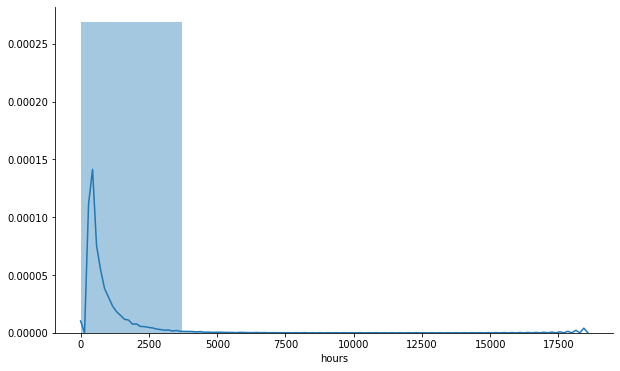

In [19]:
# Distribucion de los pesos con que se clasifican los juegos
plt.figure(figsize=(10,6))
seaborn.distplot(reviews['hours'].dropna(), bins=5)
seaborn.despine()

Creemos que es la columna hours indica si le gusto al usuario o no el juego.
Normalicemos las horas de juego

In [21]:
reviews['hours'].max()

18570.9

In [22]:
reviews['hours'].min()

0.0

## Ejercicio 2 - Sistema de Recomendación Basado en Usuarios

Este sistema de recomendación deberá entrenar un algoritmo y desarrollar una interfaz que, dado un usuario, le devuelva una lista con los juegos más recomendados.

In [ ]:
# Completar
#vemos que user_id no los tiene completos veamos como completarlos

In [18]:
reviews[['user_id','product_id','hours']].head()

,user_id,product_id,hours
0,NaN,17510,23.8
1,7.656120e+16,10180,100.2
2,7.656120e+16,320840,2.7
3,NaN,6060,8.5
4,NaN,433340,19.3


In [22]:
reviews['username'].unique()

array(['xXx_THOTDESTROYER_xXx', 'ProletusMAXIMUS', 'museste', ...,
       'zaffron', 'SeraphisCain', '[KOREA]Mary'], dtype=object)

In [36]:
reviews['username'][:200].head()

0    xXx_THOTDESTROYER_xXx
1          ProletusMAXIMUS
2                  museste
3      Totally Not Michael
4      Undercooked Lasagna
Name: username, dtype: object

In [32]:
# Creamos username_id a partir del nombre con id nuevo, ya que los ids estan mal, pero
# como vimos arriba al ser tantos nos quedamos con los 200 primeros
username_ids = {}
for idu, names in enumerate(reviews['username'].unique()[:200]):
    username_ids[idu] = reviews['username'].unique()[idu]
print(len(username_ids))    

200


In [39]:
username_ids

{0: 'xXx_THOTDESTROYER_xXx',
 1: 'ProletusMAXIMUS',
 2: 'museste',
 3: 'Totally Not Michael',
 4: 'Undercooked Lasagna',
 5: 'Prognome',
 6: 'FitzTalbot',
 7: 'Marcelo',
 8: 'Waitedboat4',
 9: 'Magic Max',
 10: 'bobnewrobot',
 11: 'Wiggles',
 12: 'Súper messi',
 13: 'K-ru',
 14: 'madpoet',
 15: 'LordInferno',
 16: 'J_ToSaveTheDay',
 17: 'FredBrooker',
 18: 'Pi55Pot',
 19: 'Micanful',
 20: 'smelly virgin',
 21: 'Lazystoner',
 22: 'Ace',
 23: 'Bill Nye Saves the world',
 24: 'Awake! Judgement Gun Morphing!',
 25: 'Fidelis',
 26: 'CryogenicFreeze',
 27: 'Comrades Before Capitalism',
 28: 'wiggs is the shiggs',
 29: 'Bouddi',
 30: "It's Just Aj Man",
 31: 'MacTombs',
 32: 'Thetigerisariver',
 33: 'Gropalopagus',
 34: 'Devilbronk666',
 35: 'Sole :)',
 36: 'Clone303',
 37: 'Matheuspontes14',
 38: 'melo',
 39: '╰<Revan The Dragon>╯',
 40: 'CraZY',
 41: 'Jiggly Josh',
 42: 'Sickhead',
 43: 'Terry',
 44: 'Spider',
 45: 'Zanes',
 46: 'Ready Player One ‡ð‡',
 47: 'マリズ',
 48: 'Lievly',
 49: 'Harem

In [49]:
username_ids.values()

dict_values(['xXx_THOTDESTROYER_xXx', 'ProletusMAXIMUS', 'museste', 'Totally Not Michael', 'Undercooked Lasagna', 'Prognome', 'FitzTalbot', 'Marcelo', 'Waitedboat4', 'Magic Max', 'bobnewrobot', 'Wiggles', 'Súper messi', 'K-ru', 'madpoet', 'LordInferno', 'J_ToSaveTheDay', 'FredBrooker', 'Pi55Pot', 'Micanful', 'smelly virgin', 'Lazystoner', 'Ace', 'Bill Nye Saves the world', 'Awake! Judgement Gun Morphing!', 'Fidelis', 'CryogenicFreeze', 'Comrades Before Capitalism', 'wiggs is the shiggs', 'Bouddi', "It's Just Aj Man", 'MacTombs', 'Thetigerisariver', 'Gropalopagus', 'Devilbronk666', 'Sole :)', 'Clone303', 'Matheuspontes14', 'melo', '╰<Revan The Dragon>╯', 'CraZY', 'Jiggly Josh', 'Sickhead', 'Terry', 'Spider', 'Zanes', 'Ready Player One ‡ð‡', 'マリズ', 'Lievly', 'Haremhaton', 'Timmy', 'S̴o̦l̺™͙̦̮̥̤̻̣͠', 'FiX`Leon', '[BSB] Rhym3z', 'Magical_Pony_Warrior', 'Grimm', 'Legend', '[GHPC] Callabaddie', 'SolarBear', 'SnackTimeCat', 'Lunaticon', 'iamthe3', 'CB', 'voltzila', 'McJesus', 'Loskoron', 'Dee

In [60]:
#
username_id_column = []
for i in reviews['username'][:200]:
    #print(i)
    if i in username_ids.values():
        #print(i)
        #print(list(username_ids.keys())[list(username_ids.values()).index(i)])
        username_new = list(username_ids.keys())[list(username_ids.values()).index(i)]
        #print(username_new)
        username_id_column.append(username_new)
print(len(username_id_column))

200


In [61]:
df_reviews = reviews[:200].fillna(0)
df_reviews['user_id'] = username_id_column
df_reviews.to_csv("df_reviews.csv")

In [62]:
df_reviews[['user_id','product_id','hours']].head()

,user_id,product_id,hours
0,0,17510,23.8
1,1,10180,100.2
2,2,320840,2.7
3,3,6060,8.5
4,4,433340,19.3


In [70]:
from surprise import Dataset, Reader, KNNWithMeans, KNNBasic, NormalPredictor, KNNWithZScore
from surprise.model_selection import cross_validate, train_test_split
from surprise.accuracy import rmse

In [65]:
reader = Reader(rating_scale=(df_reviews.hours.min(), df_reviews.hours.max()))
videogames = Dataset.load_from_df(df_reviews[["user_id", "product_id", "hours"]], reader)

In [68]:
ratings_train, ratings_test = train_test_split(videogames, test_size=0.4)

In [71]:
model = KNNWithMeans(k=5).fit(ratings_train)
predictions = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 120.7828


In [75]:
#cross validation
reviews_games = pd.read_csv("df_reviews.csv")

In [77]:
model = KNNWithMeans(k=5, verbose=False)
cross_validated_metrics = cross_validate(model, videogames, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    83.9166 281.7959145.084596.6385 305.4400182.575193.2359 
MAE (testset)     71.7544 106.092079.8777 76.3303 132.434393.2977 22.9237 
Fit time          0.01    0.01    0.00    0.00    0.00    0.00    0.00    
Test time         0.01    0.00    0.00    0.00    0.00    0.00    0.00    


In [86]:
from scipy.sparse import csr_matrix
import numpy

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        artist_mapper: dict that maps user id's to artist indices
        user_inv_mapper: dict that maps user indices to user id's
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
    """
    M = df['user_id'].nunique()
    N = df['product_id'].nunique()

    artist_mapper = dict(zip(numpy.unique(df['user_id']), list(range(M))))
    user_mapper = dict(zip(numpy.unique(df["product_id"]), list(range(N))))
    
    artist_inv_mapper = dict(zip(list(range(M)), numpy.unique(df['user_id'])))
    user_inv_mapper = dict(zip(list(range(N)), numpy.unique(df["product_id"])))
    
    artist_index = [artist_mapper[i] for i in df['user_id']]
    item_index = [user_mapper[i] for i in df['product_id']]

    X = csr_matrix((df["hours"], (artist_index,item_index)), shape=(M,N))
    
    return X, artist_mapper, user_mapper, artist_inv_mapper, user_inv_mapper

X, user_mapper, product_mapper, user_inv_mapper, product_inv_mapper = create_X(reviews_games)

In [89]:
def find_similar_games(games_id, X, games_mapper, games_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        artist_id: id of the artist of interest
        X: user-artist utility matrix
        k: number of similar artist to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar artist ID's
    """
    X = X.T
    games_ids = []
    
    games_ind = artist_mapper[games_id]
    games_vec = X[games_ind]
    if isinstance(games_vec, (numpy.ndarray)):
        games_vec = games_vec.reshape(1,-1)
    
    # use k+1 since kNN output includes the artistID of interest
    kNN = NearestNeighbors(n_neighbors = k + 1, algorithm = 'brute', metric = metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(artist_vec, return_distance = False)
    
    for i in range(0, k):
        n = neighbour.item(i)
        games_ids.append(games_inv_mapper[n])
        
    games_ids.pop(0)
    return games_ids

In [88]:
n_ratings_per_game = X.getnnz(axis=0)

print(f"Most rated game has {n_ratings_per_game.max()} ratings.")
print(f"Least rated game has {n_ratings_per_game.min()} ratings.")

Most rated game has 6 ratings.
Least rated game has 1 ratings.


## Ejercicio 3 - Sistema de Recomendación Basado en Juegos

Similar al caso anterior, con la diferencia de que este sistema espera como entrada el nombre de un juego y devuelve una lista de juegos similares. El sistema deberá estar programado en base a información de contenido de los juegos (i.e. filtrado basado en contenido o sistema híbrido).

In [92]:
games['title'].head

<bound method NDFrame.head of 0                                      Lost Summoner Kitty
1                                                Ironbound
2                                  Real Pool 3D - Poolians
3                                                  弹炸人2222
4                                                     None
5                                    Battle Royale Trainer
6                             SNOW - All Access Basic Pass
7                               SNOW - All Access Pro Pass
8                            SNOW - All Access Legend Pass
9                                                     Race
10                                         Uncanny Islands
11                                                    None
12       Army of Tentacles: (Not) A Cthulhu Dating Sim:...
13                                             Beach Rules
14                             Planetarium 2 - Zen Odyssey
15                                 The first thrust of God
16                        

In [99]:
games['title']

0                                      Lost Summoner Kitty
1                                                Ironbound
2                                  Real Pool 3D - Poolians
3                                                  弹炸人2222
4                                                     None
5                                    Battle Royale Trainer
6                             SNOW - All Access Basic Pass
7                               SNOW - All Access Pro Pass
8                            SNOW - All Access Legend Pass
9                                                     Race
10                                         Uncanny Islands
11                                                    None
12       Army of Tentacles: (Not) A Cthulhu Dating Sim:...
13                                             Beach Rules
14                             Planetarium 2 - Zen Odyssey
15                                 The first thrust of God
16                                     SNOW - Starter Pa

In [100]:
list(games.index)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [103]:
# hagamos entero en id del juego
integer_id = []
for i in games['id']:
    string = str(i)
    integer_id.append(string[:-2])
games['id'] = integer_id
games

,developer,discount_price,early_access,genres,id,metascore,price,release_date,sentiment,specs,title
0,Kotoshiro,4.49,False,"[Action, Casual, Indie, Simulation, Strategy]",761140,None,4.99,2018-01-04,None,[Single-player],Lost Summoner Kitty
1,Secret Level SRL,NaN,False,"[Free to Play, Indie, RPG, Strategy]",643980,None,Free To Play,2018-01-04,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",Ironbound
2,Poolians.com,NaN,False,"[Casual, Free to Play, Indie, Simulation, Sports]",670290,None,Free to Play,2017-07-24,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",Real Pool 3D - Poolians
3,彼岸领域,0.83,False,"[Action, Adventure, Casual]",767400,None,0.99,2017-12-07,None,[Single-player],弹炸人2222
4,None,1.79,False,None,773570,None,2.99,None,None,"[Single-player, Full controller support, HTC V...",None
5,Trickjump Games Ltd,NaN,False,"[Action, Adventure, Simulation]",772540,None,3.99,2018-01-04,Mixed,"[Single-player, Steam Achievements]",Battle Royale Trainer
6,Poppermost Productions,NaN,False,"[Free to Play, Indie, Simulation, Sports]",774276,None,9.99,2018-01-04,None,"[Single-player, Multi-player, Online Multi-Pla...",SNOW - All Access Basic Pass
7,Poppermost Productions,NaN,False,"[Free to Play, Indie, Simulation, Sports]",774277,None,18.99,2018-01-04,None,"[Single-player, Multi-player, Online Multi-Pla...",SNOW - All Access Pro Pass
8,Poppermost Productions,NaN,False,"[Free to Play, Indie, Simulation, Sports]",774278,None,29.99,2018-01-04,None,"[Single-player, Multi-player, Online Multi-Pla...",SNOW - All Access Legend Pass
9,RewindApp,NaN,False,"[Casual, Indie, Racing, Simulation]",768800,None,None,2018-01-04,None,"[Single-player, Multi-player, Partial Controll...",Race


In [106]:
# this makes an dictionary with the key database for all unique games
gamename_dict = {}
gamename_dictTwo = {}
for idx, names in enumerate(games['title']):
    if games['id'][idx] not in gamename_dict:
        gamename_dict[games['id'][idx]] = games['title'][idx]
        gamename_dictTwo[games['title'][idx]] = games['id'][idx]
    else:
        continue
gamename_dictTwo

{'Lost Summoner Kitty': '761140',
 'Ironbound': '643980',
 'Real Pool 3D - Poolians': '670290',
 '弹炸人2222': '767400',
 None: '681550',
 'Battle Royale Trainer': '772540',
 'SNOW - All Access Basic Pass': '774276',
 'SNOW - All Access Pro Pass': '774277',
 'SNOW - All Access Legend Pass': '774278',
 'Race': '768800',
 'Uncanny Islands': '768570',
 'Army of Tentacles: (Not) A Cthulhu Dating Sim: Black GOAT of the Woods Edition': '770380',
 'Beach Rules': '768880',
 'Planetarium 2 - Zen Odyssey': '765320',
 'The first thrust of God': '773650',
 'SNOW - Starter Pack': '774271',
 'The first thrust of God - All Aircrafts': '773690',
 'SNOW - Lifetime Pack': '774279',
 'The Warrior Of Treasures': '768060',
 'RC Plane 3 - Canyon Scenario': '775880',
 'RC Plane 3 - F-53B': '775881',
 'DinoBlaster': '653960',
 'Robotpencil Presents: Understanding 3D for Concept': '777910',
 'Carmageddon Max Pack': '282010',
 'Half-Life': '70',
 'Fallen Mage': '752360',
 'Lost Cities': '520680',
 'Twisted Enhance

In [110]:
def games_finder(title):
    if title!=None: games[games['title'].str.contains(title)]['title'].tolist()
    return None

#games_idx = dict(zip(games['title'], list(games.index)))
#games_idx
idx = gamename_dictTwo['Ironbound']
n_recommendations = 5
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_games = [i[0] for i in sim_scores]
print("Recomendaciones para {}:".format(title))
for game in games['title'].iloc[similar_games]:
    print("\t{}".format(game))

NameError: name 'cosine_sim' is not defined

In [91]:
#def games_finder(title):
#    return games[games['title'].str.contains(title)]['title'].tolist()

#games_idx = dict(zip(games['title'], list(games.index)))
#title = games_finder('Ironbound')[0]
n_recommendations = 5

idx = games_idx[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_games = [i[0] for i in sim_scores]

print("Recomendaciones para {}:".format(title))
for game in games['title'].iloc[similar_games]:
    print("\t{}".format(game))

ValueError: cannot index with vector containing NA / NaN values